In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv
import yaml

import os
import cv2
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from torch.cuda.amp import autocast, GradScaler

C:\Users\matsvei\AppData\Local\Temp\ipykernel_6220\3215403538.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
option_path = 'config.yaml'
with open(option_path, 'r') as file_option:
    option = yaml.safe_load(file_option)


In [9]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
            
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # bgr to rgb
        img = img.astype(np.float32)
        img = img / 255.0
        
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        
        img = img.transpose([2, 0, 1])
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
        
        return {'img': t_img, 'label': t_class_id}

    

In [10]:
train_dogs_path = option['train_dogs_path']
train_cats_path = option['train_cats_path']

test_dogs_path = option['test_dogs_path']
test_cats_path = option['test_cats_path']

# train_dogs_path = 'D:/matvei/datasets/dogs_and_cats/training_set/dogs'
# train_cats_path = 'D:/matvei/datasets/dogs_and_cats/training_set/cats'

# test_dogs_path = 'D:/matvei/datasets/dogs_and_cats/test_set/dogs'
# test_cats_path = 'D:/matvei/datasets/dogs_and_cats/test_set/cats'


train_ds_catdogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catdogs = Dataset2class(test_dogs_path, test_cats_path)


In [12]:
batch_size = option['batch_size']


train_loader = torch.utils.data.DataLoader(
    train_ds_catdogs, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True
    )

test_loader = torch.utils.data.DataLoader(
   test_ds_catdogs, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False
   )

In [13]:
model_res = tv.models.resnet.resnet34

In [14]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)
        
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        #out = self.norm1(out)
        
        return x + out #self.act(x + out)

In [15]:
class BottleneckBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.act = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv0 = nn.Conv2d(nc, nc//4, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(nc//4)
        self.conv1 = nn.Conv2d(nc//4, nc//4, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc//4)
        self.conv2 = nn.Conv2d(nc//4, nc, kernel_size=1, padding=0)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)

        return x + out #self.act(x + out)

In [16]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks, block_type='classic'):
        super().__init__()
        truck = []
        for i in range(num_blocks):
            if block_type == 'classic':
                truck.append(ResBlock(nc))
            elif block_type == 'bottleneck':
                truck.append(BottleneckBlock(nc))
            else:
                raise NotImplementedError(f'{block_type} is not implemented')
                
                
    
        self.truck = nn.Sequential(*truck)
        
    def forward(self, x):
        return self.truck(x)

In [17]:
class ResNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc, block_type='bottleneck'):
        super().__init__()
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.layer1 = ResTruck(nc, 3, block_type=block_type)
        self.conv1 = nn.Conv2d(nc, 2*nc, 3, padding=1, stride=2)
        self.layer2 = ResTruck(2*nc, 4, block_type=block_type)
        self.conv2 = nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=2)
        self.layer3 = ResTruck(4*nc, 6, block_type=block_type)
        self.conv3 = nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=2)
        self.layer4 = ResTruck(4*nc, 3, block_type=block_type)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)
    
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        
        return out

In [18]:
in_nc = option['network']['in_nc']
base_nc = option['network']['base_nc']
out_nc = option['network']['out_nc']

model = ResNet(in_nc, base_nc, out_nc)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
count_parameters(model)

1685986

In [21]:
for sample in train_loader:
    img = sample['img']
    label = sample['label']
    model(img)
    break

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, 
    gamma=0.6
)

In [23]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach(), dim=1).numpy().argmax(axis=1) == label.numpy().argmax(axis=1)
    return answer.mean()


In [24]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [25]:
model = model.float().to(DEVICE)
loss_fn = loss_fn.to(DEVICE)


In [26]:
use_amp = True
scaler = torch.amp.GradScaler('cuda')

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [27]:
epochs = 10
loss_epochs_list = []
acc_epochs_list = []

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    pbar = tqdm(train_loader)
    for sample in pbar:
        img, label = sample['img'], sample['label']
        label = F.one_hot(label, 2).float()
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            img = img.float()
            pred = model(img)
            loss = loss_fn(pred, label)
            
        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        scaler.step(optimizer)
        scaler.update()
        
        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current
        
        pbar.set_description(f'loss: {loss_item:.4f}\taccuracy: {acc_current:3f}')
    scheduler.step()
    loss_epochs_list.append(loss_val / len(train_loader))
    acc_epochs_list.append(acc_val / len(train_loader))
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])
        
        
            
            
        

  0%|          | 0/500 [00:00<?, ?it/s]

0.7193135257959365
0.57475


  0%|          | 0/500 [00:00<?, ?it/s]

0.6369509515762329
0.64


  0%|          | 0/500 [00:00<?, ?it/s]

0.5938798699378968
0.681875


  0%|          | 0/500 [00:00<?, ?it/s]

0.5487758014798164
0.717625


  0%|          | 0/500 [00:00<?, ?it/s]

0.48908864659070966
0.75875


  0%|          | 0/500 [00:00<?, ?it/s]

0.44223903548717497
0.7905


  0%|          | 0/500 [00:00<?, ?it/s]

0.3916910201013088
0.819875


  0%|          | 0/500 [00:00<?, ?it/s]

0.3508894486427307
0.845375


  0%|          | 0/500 [00:00<?, ?it/s]

0.3228764202296734
0.8595


  0%|          | 0/500 [00:00<?, ?it/s]

0.29594498857855794
0.8745


In [69]:
loss_epochs_list_resnet_v3 = loss_epochs_list.copy()
acc_epochs_list_resnet_v3 = acc_epochs_list.copy()

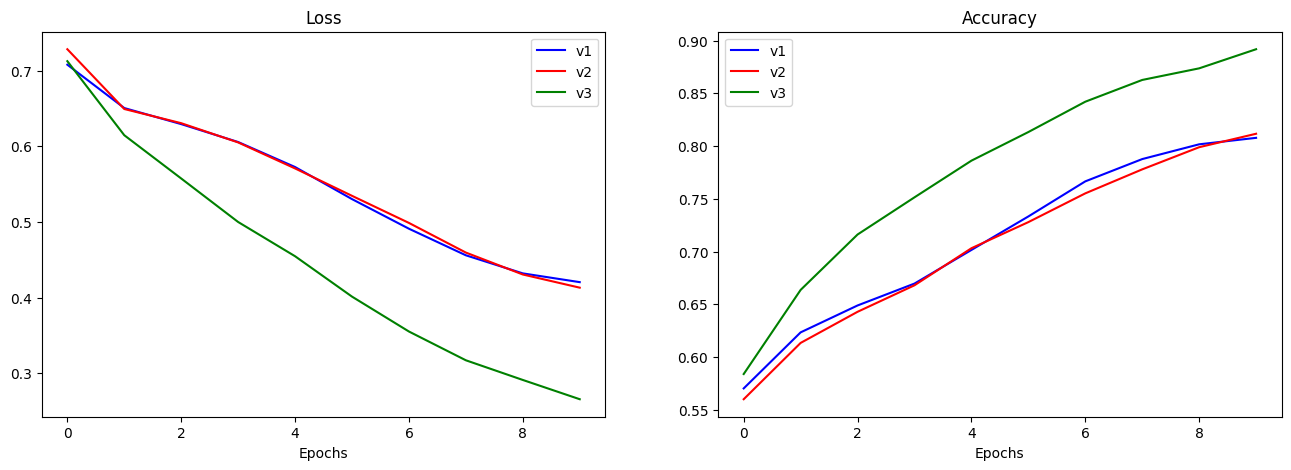

In [70]:
# two graph loss and accuracy

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.plot(loss_epochs_list_resnet_v1, color='blue')
plt.plot(loss_epochs_list_resnet_v2, color='red')
plt.plot(loss_epochs_list_resnet_v3, color='green')
plt.legend(['v1', 'v2', 'v3'])

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.plot(acc_epochs_list_resnet_v1, color='blue')
plt.plot(acc_epochs_list_resnet_v2, color='red')
plt.plot(acc_epochs_list_resnet_v3, color='green')
plt.legend(['v1', 'v2', 'v3'])
plt.show()

In [73]:
model.eval()
test_loss = 0.0
test_acc = 0.0

for sample in tqdm(test_loader):
    with torch.no_grad():
        img, label = sample['img'], sample['label']
        
        img = img.to(DEVICE)
        label = F.one_hot(label, 2).float()
        label = label.to(DEVICE)
        pred = model(img)


        loss = loss_fn(pred, label)
        test_loss += loss.item()
        batch_acc = accuracy(pred.cpu().float(), label.cpu().float())
        test_acc += batch_acc.item()

avg_test_loss = test_loss / len(test_loader)
avg_test_acc = test_acc / len(test_loader)

print(f'Test Loss: {avg_test_loss:.5f}, Test Accuracy: {avg_test_acc:.3f}')

  0%|          | 0/125 [00:00<?, ?it/s]

Test Loss: 0.43335, Test Accuracy: 0.815


In [82]:
def lusa_test(lusa_path):   
    lusa = cv2.imread(lusa_path, cv2.IMREAD_COLOR)
    lusa = cv2.cvtColor(lusa, cv2.COLOR_BGR2RGB)
    plt.imshow(lusa)
    plt.title("Фото животоного")
    plt.axis("off")
    plt.show()
    
    lusa = lusa.astype(np.float32) 
    lusa = lusa / 255.0 
    lusa = cv2.resize(lusa, (224, 224), interpolation=cv2.INTER_AREA)
        
    lusa = lusa.transpose([2, 0, 1])
    lusa_t = torch.from_numpy(lusa).unsqueeze(0) 
    lusa_class_id = torch.tensor(1)
    
    with torch.no_grad():
        lusa_t = lusa_t.float().to(DEVICE)
        lusa_class_id = lusa_class_id.long().to(DEVICE)
        pred = model(lusa_t)

        probability = torch.sigmoid(pred)
        prob_dog = probability[0, 0].item()
        
        prob_cat = probability[0, 1].item()
        print(f"Вероятность, что это кошка: {prob_cat:.4f}")
        print(f"Вероятность, что это собака: {prob_dog:.4f}")

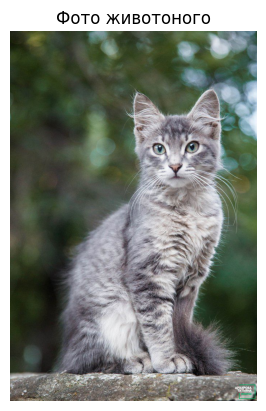

Вероятность, что это кошка: 0.9141
Вероятность, что это собака: 0.0447


In [102]:
path_lusa_1 = 'D:/matvei/datasets/dogs_and_cats/true_imgs/cat2.jpg'
lusa_test(path_lusa_1)